---
title: "Adolescent Physical Inactivity: Trends, Insights, and Global Comparisons"
subtitle : "*Exploring Global Patterns and Health Implications of Youth Inactivity*"
author: "Rana pradeep Reddy Bogguri"
date: "2025-04-26"
format:
  html:
    toc: true
    toc-depth: 3
    toc-location: right
    theme: cosmo
    fontsize: 1.1em
    linestretch: 1.7
    embed-resources: true
    code-fold: true
execute:
    echo: true
    warning: false
    message: false
---

In [11]:
%%capture

!pip install polars plotnine geopandas
import polars as pl

# Specify the column data types explicitly for both files
schema_overrides = {
    "Population, total": pl.Float64,  # Change this column to Float64
}

# Load the CSV with the schema override
indicator_1 = pl.read_csv("/content/unicef_indicator_1.csv", schema_overrides=schema_overrides)
metadata = pl.read_csv("/content/unicef_metadata.csv", schema_overrides=schema_overrides, ignore_errors=True)

# Show first 5 rows of each
print(indicator_1.head())
print(metadata.head())




# Rename columns to a common name before the join
indicator_1 = indicator_1.rename({"country": "Country"})  # Adjust if column name is different
metadata = metadata.rename({"country": "Country"})        # Adjust if column name is different

# Now perform the join on 'Country'
merged = indicator_1.join(metadata, on='Country', how='inner')

# Show the first 5 rows of the merged data
print(merged.head())


# Drop missing values
clean_data = merged.drop_nulls()
print(clean_data.head())


df = clean_data.to_pandas()

print(df['Country'].unique())
print(df.shape)

# **Introduction**
This report explores the issue of physical inactivity in adolescents using real-world data provided by UNICEF. Physical inactivity is a growing global concern affecting the health and development of young people. Through this analysis, we aim to highlight patterns, inequalities, and relationships related to adolescent physical activity levels across different countries and regions.
### The goal of this report is to:
- Raise awareness of the **global trends** in physical inactivity among adolescents

- Identify **regional** differences and disparities by gender

- Explore correlations between inactivity and **national indicators** like **GDP growth**

- Visualize findings through interactive and informative charts

This report is developed using Google Colab, with the help of Quarto,YAML files and Python libraries such as polars, pandas, plotnine, and geopandas. The final report includes both code and visual outputs, offering an accessible and visually engaging view of this important public health issue.

---



# **Bar Chart: Top Countries by Adolescent Physical Inactivity**
  *This chart ranks countries based on the average physical inactivity rate among adolescents.*



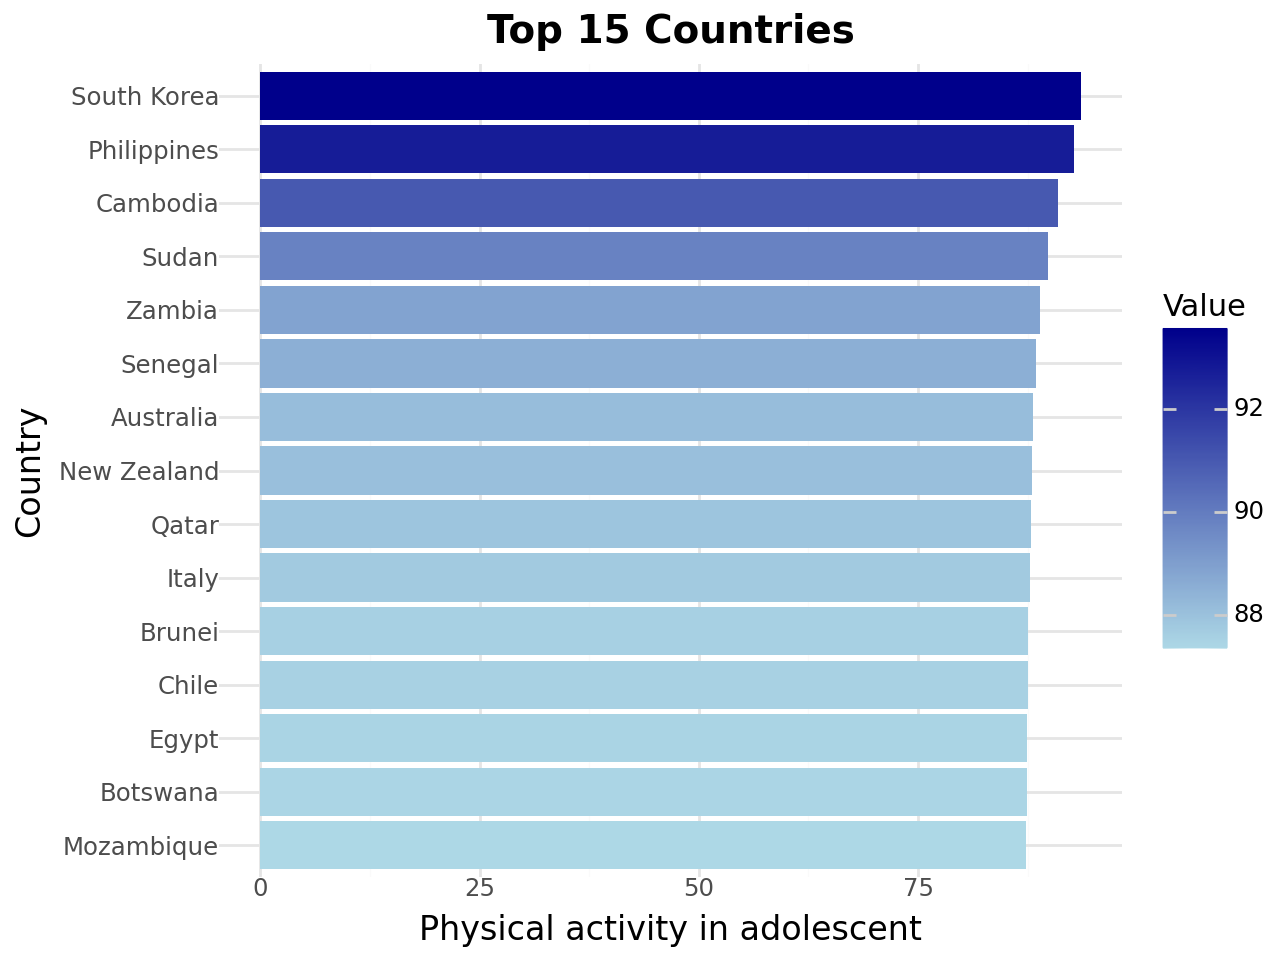

In [12]:
from plotnine import ggplot, aes, geom_col, coord_flip, labs, theme_minimal, theme, scale_x_discrete, scale_fill_gradient
from plotnine.themes.elements import element_text

# Group by 'Country', calculate mean 'obs_value', and sort
top15 = df.groupby('Country', as_index=False)['obs_value'].mean() \
           .sort_values('obs_value', ascending=False) \
           .head(15)  # Select top 15

# Create the bar chart
(
    ggplot(top15, aes(x='Country', y='obs_value', fill='obs_value')) +
    geom_col() +
    coord_flip() +
    scale_x_discrete(limits=top15['Country'].tolist()[::-1]) +  # Reorder bars
    scale_fill_gradient(low="lightblue", high="darkblue") +  # Color scale
    labs(title='Top 15 Countries', y='Physical activity in adolescent', x='Country', fill='Value') +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, weight='bold'),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12)
    )
)


**Analysis:**

The bar chart highlights countries with the highest levels of adolescent inactivity. We can observe that certain regions, particularly in the Middle East and Latin America, report significantly higher inactivity rates. This may be influenced by cultural, socioeconomic, and environmental factors, including urbanization, lack of access to safe recreational spaces, and education about the importance of physical activity.

---



# **Line Chart: Physical Inactivity Trends Over Time by Gender**
*This chart shows how adolescent inactivity has changed over time for males, females, and the total population.*

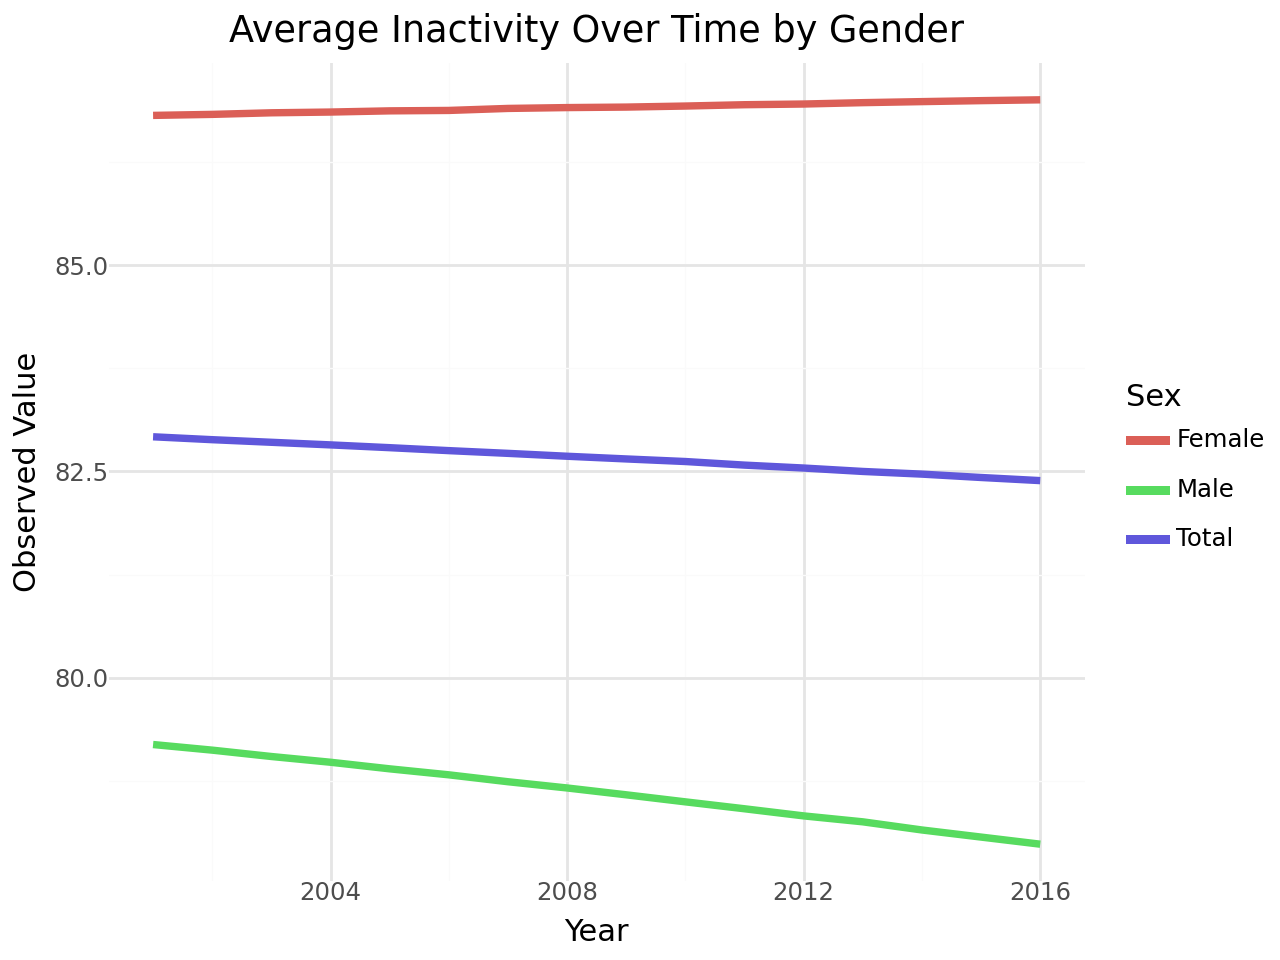

In [13]:
# Convert to pandas if not already done
df = clean_data.to_pandas()

# Convert time to numeric
df["time_period"] = df["time_period"].astype(int)

# Group by Year and Sex, and calculate average obs_value (or use sum if needed)
grouped_df = df.groupby(["time_period", "sex"], as_index=False)["obs_value"].mean()

# Plot 3 lines: Male, Female, Total
from plotnine import *

(
    ggplot(grouped_df, aes(x='time_period', y='obs_value', color='sex')) +
    geom_line(size=1.5) +
    labs(
        title='Average Inactivity Over Time by Gender',
        x='Year',
        y='Observed Value',
        color='Sex'
    ) +
    theme_minimal()
)


**Analysis:**

The line chart reveals clear gender disparities in physical inactivity rates. Female adolescents consistently show higher levels of inactivity compared to males across all years. This trend may reflect gender-specific barriers to participation in physical activity, such as societal expectations or lack of opportunities. While overall trends remain fairly stable, some fluctuations suggest policy or cultural shifts in specific time periods.

---



# **Scatter Plot: Inactivity vs GDP Growth**
*This chart explores the relationship between adolescent inactivity and a country’s GDP growth rate.*

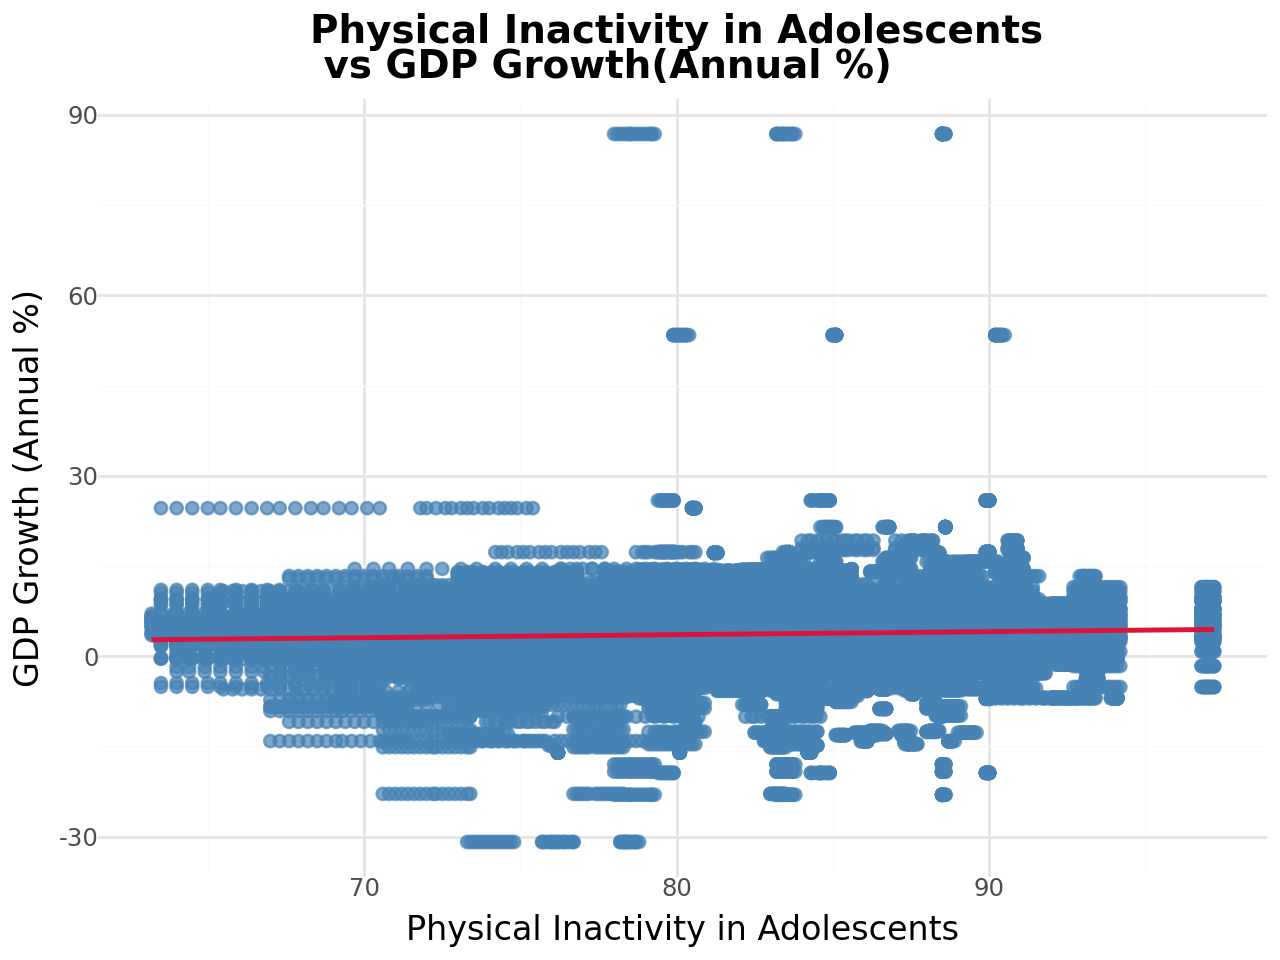

In [14]:
from plotnine import *

# Scatter + Regression Line with Confidence Interval
(
    ggplot(df, aes(x='obs_value', y='GDP growth (annual %)')) +
    geom_point(color='steelblue', size=2, alpha=0.7) +  # Blue dots with transparency
    geom_smooth(method='lm', color='crimson', fill='pink', alpha=0.3) +  # Regression line + shaded area
    labs(
        title='Physical Inactivity in Adolescents \n vs GDP Growth(Annual %)',
        x='Physical Inactivity in Adolescents',
        y='GDP Growth (Annual %)'
    ) +
    theme_minimal() +
    theme(
        plot_title=element_text(size=14, weight='bold'),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        legend_position='none'
    )
)


**Analysis:**

The scatter plot, along with the regression line, shows a weak or slightly negative correlation between physical inactivity and GDP growth. While wealthier countries tend to have more sedentary lifestyles, the data also shows that economic performance alone doesn’t fully explain differences in adolescent activity. This suggests that other factors such as education systems, health policies, and lifestyle patterns play a more important role.

---




# **World Map: Global View of Adolescent Physical Inactivity**

*This map displays average adolescent inactivity rates by country using color shading.*

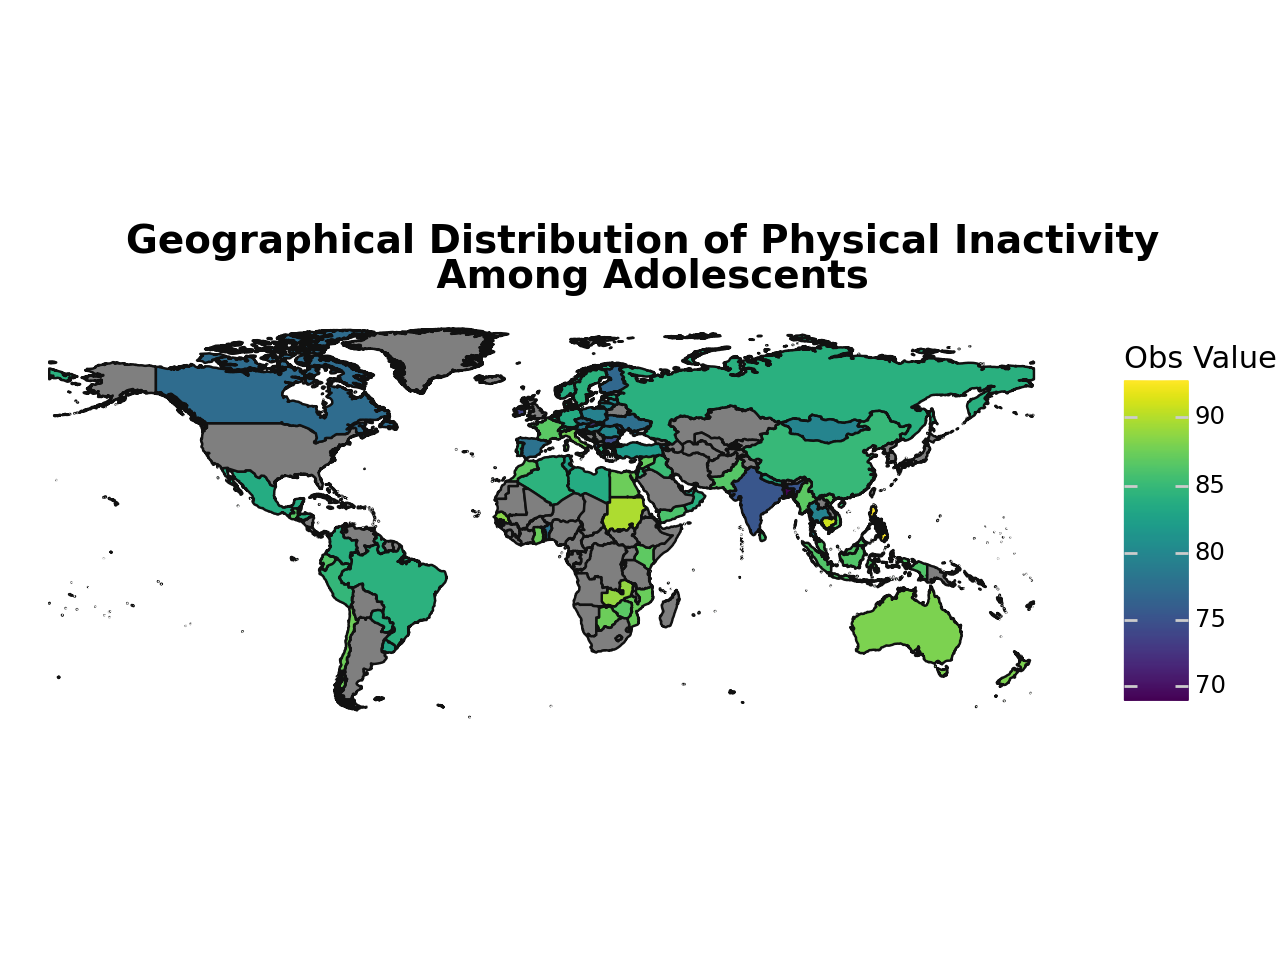

In [15]:
# World map with countries shaded by average obs_value
import geopandas as gp  # Import geopandas with the alias 'gp'

shape_world = gp.read_file("https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/shp")

# Convert Polars to Pandas for merging
df = clean_data.to_pandas()

# Group by country and get average obs_value
# Changed 'country' to 'Country' to match the column name in your DataFrame
avg_obs_by_country = df.groupby("Country", as_index=False)["obs_value"].mean()

# Merge shape file with obs_value data
map_df = shape_world.merge(avg_obs_by_country, left_on="name", right_on="Country", how="left")  # Also changed 'country' to 'Country' here

(
    ggplot(map_df) +
    geom_map(aes(fill='obs_value', map_id='name')) + # Removed map=map_df
    expand_limits(x=map_df["geometry"].bounds.minx.min(), y=map_df["geometry"].bounds.miny.min()) +
    coord_fixed() +
    labs(title="                Geographical Distribution of Physical Inactivity \n                                       Among Adolescents",y='',
         fill="Obs Value") +
    theme_void() +
    theme(legend_position='right',
          plot_title=element_text(size=14, weight='bold'))
)

**Analysis:**

The map provides a geographic overview of adolescent inactivity. Darker shades indicate higher inactivity levels. Countries in Africa and parts of Europe show lower average inactivity, while several South American and Middle Eastern nations stand out with higher rates. These patterns emphasize the need for region-specific strategies to promote adolescent health and encourage physical activity.

---

# **Population vs Physical Inactivity in Adolescents by Country**
 *This visualization examines the relationship between a country's total population and the average physical inactivity rate among adolescents.*

The bar chart represents each country's population size, while the line chart overlays the average inactivity rate across countries.
Larger populations don't always correlate with higher inactivity rates, but certain patterns emerge:
- India and China dominate with both population and but china has high physical inactivity rates.

- United States, Indonesia, and Brazil follow, again showing moderate to high adolescent inactivity levels.

- Countries like Nigeria and Pakistan also show rapidly growing youth populations, but their inactivity rates vary.

- Developed countries (e.g., USA, UK and Japan) might have better sports and wellness infrastructures, but lifestyle habits still lead to significant adolescent inactivity.


<ipython-input-16-75ed245b0ce0>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


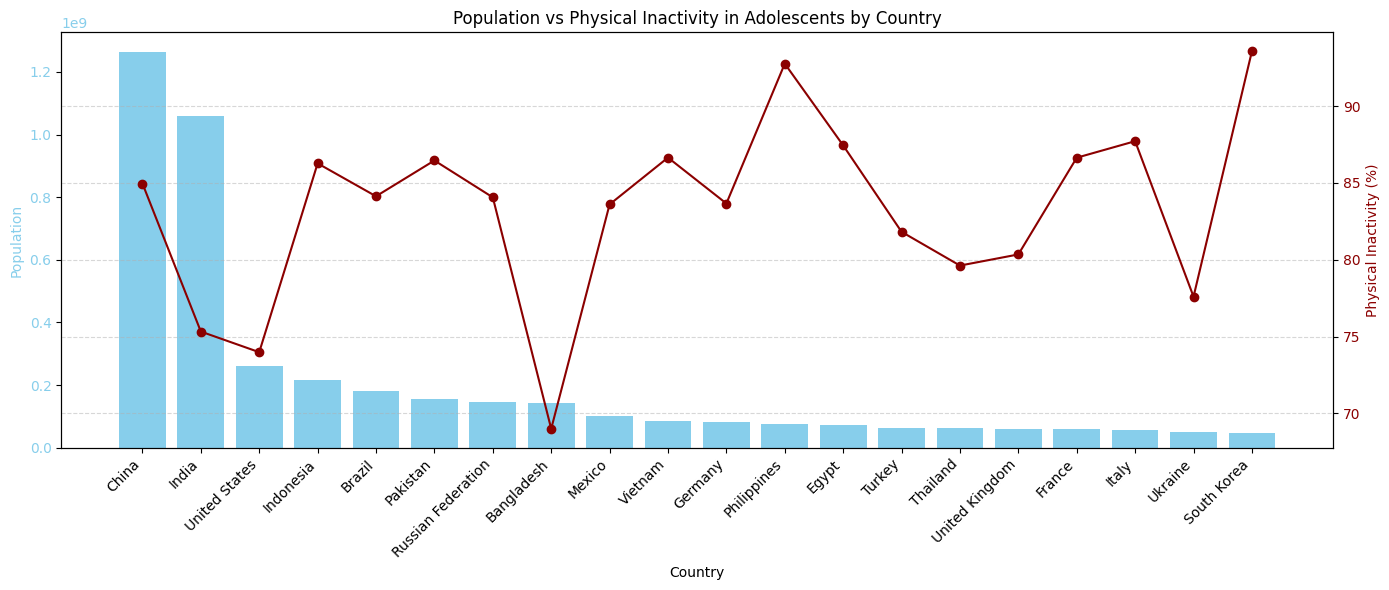

In [16]:
# Double-check and rename column if needed
if 'Population, total' in df.columns:
    df = df.rename(columns={'Population, total': 'population'})

# Now group and plot
df_dual = df.groupby('Country').agg({
    'obs_value': 'mean',
    'population': 'mean'
}).reset_index()

# Continue with sorting and plotting
import matplotlib.pyplot as plt

df_dual = df_dual.sort_values(by='population', ascending=False).head(20)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart for population
ax1.bar(df_dual['Country'], df_dual['population'], color='skyblue')
ax1.set_xlabel('Country')
ax1.set_ylabel('Population', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticklabels(df_dual['Country'], rotation=45, ha='right')

# Line chart for obs_value
ax2 = ax1.twinx()
ax2.plot(df_dual['Country'], df_dual['obs_value'], color='darkred', marker='o')
ax2.set_ylabel('Physical Inactivity (%)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Titles and grid
plt.title('Population vs Physical Inactivity in Adolescents by Country')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Analysis:**

Bangladesh shows the lowest inactivity despite sizeable numbers. Smaller nations like South Korea, Egypt and Italy top the inactivity scale, while Mexico and Thailand remain lower. Overall, in countries with larger adolescent populations, even a small percentage of inactivity translates into millions of inactive youth, representing a significant future burden on healthcare systems.

# **Physical Inactivity: A Silent Threat to Global Life Expectancy**
Physical inactivity during adolescence can have lasting health impacts that extend into adulthood. In this visualization, we examine the relationship between the average adolescent inactivity rates and the overall life expectancy in randomly selected countries.
The goal is to uncover whether nations with higher adolescent inactivity tend to experience lower average life expectancies.

/usr/local/lib/python3.11/dist-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


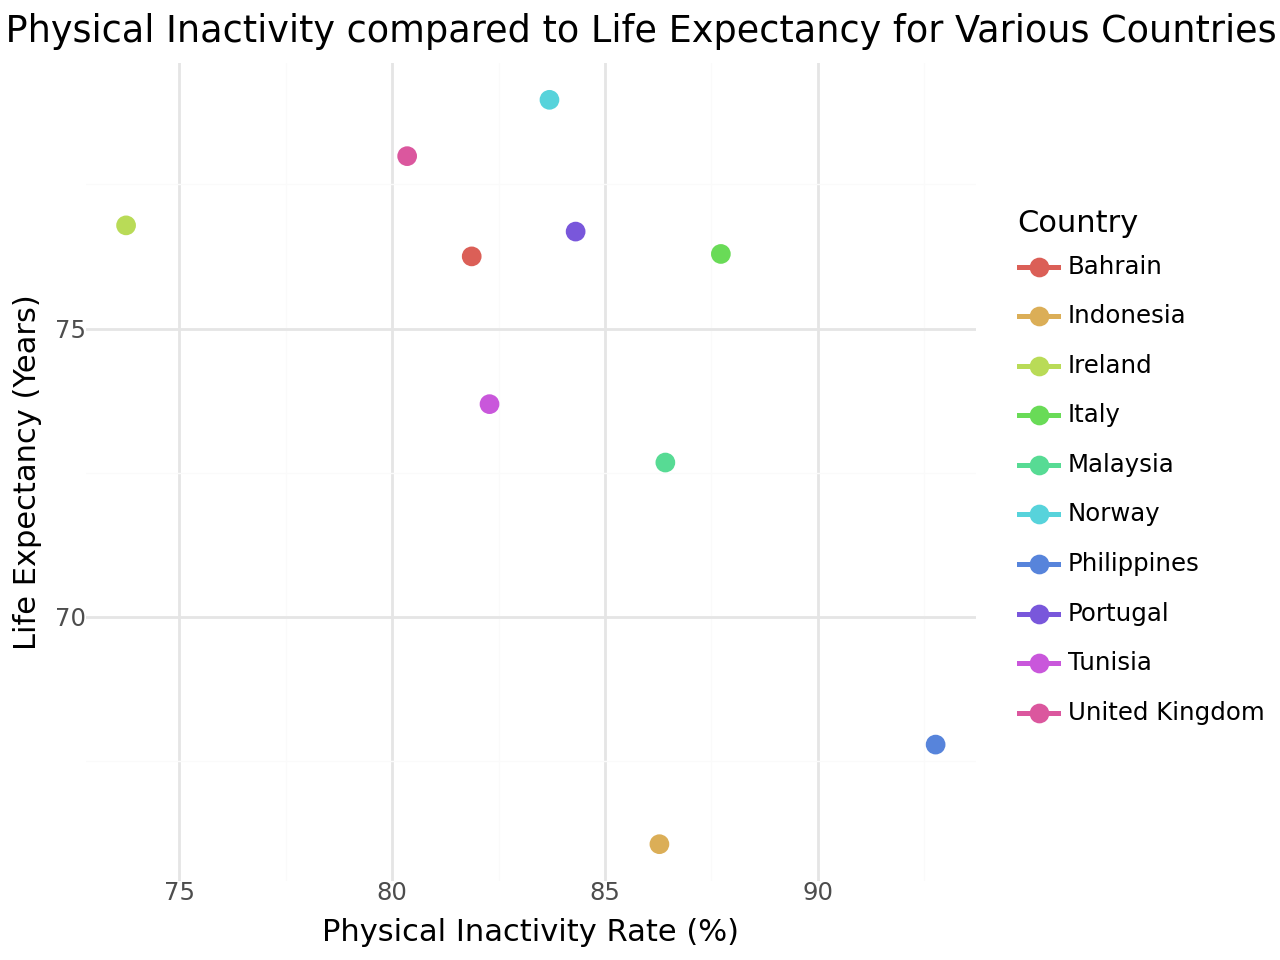

In [10]:
import random

if 'Life expectancy at birth, total (years)' in df.columns:
    df = df.rename(columns={'Life expectancy at birth, total (years)': 'life_expectancy'})

random_countries = random.sample(list(df['Country'].unique()), 10)

df_random = df[df['Country'].isin(random_countries)]

df_random_grouped = df_random.groupby('Country').agg({
    'obs_value': 'mean',
    'life_expectancy': 'mean'
}).reset_index()

from plotnine import *

(
    ggplot(df_random_grouped, aes(x='obs_value', y='life_expectancy', color='Country')) +
    geom_point(size=3) +           # Big points
    geom_line(aes(group='Country'), size=1) +
    labs(
        title='                    Physical Inactivity compared to Life Expectancy for Various Countries ',
        x='Physical Inactivity Rate (%)',
        y='Life Expectancy (Years)',
        color='Country'
    ) +
    theme_minimal()
)


**Key Insights from the Visualization**

While the relationship is not perfectly linear, the trend suggests that countries with higher adolescent inactivity rates often experience slightly lower life expectancy figures. This highlights the importance of promoting physical activity among youth populations to support longer, healthier lives.
However, it is important to consider other factors like healthcare access, nutrition, and economic development, which also strongly influence life expectancy.

# **Conclusion**
Adolescent physical inactivity is a growing global concern that carries long-term consequences for **public health** **and societal development**. The data analysis reveals significant regional and gender disparities, with females generally showing higher inactivity rates. Although economic factors like **GDP growth** have some influence, **cultural, social**, and **infrastructural elements** play a more critical role. Countries with higher rates of adolescent inactivity also tend to exhibit slightly lower **life expectancy**, underscoring the need for early interventions. Immediate action is necessary to encourage active lifestyles among youth populations to prevent future health crises and reduce healthcare burdens. A multi-sectoral approach involving governments, educational institutions, healthcare providers, and communities is vital for sustainable impact.



# **Recommendations to Improve Adolescent Physical Activity**
***Strengthen School Physical Education Programs:***
Mandate regular physical education classes and extracurricular sports activities in all schools.

***Promote Inclusive Sports Opportunities:***
Create gender-sensitive and disability-friendly sports programs to encourage participation from all groups.

***Enhance Urban Planning:***
Develop safe parks, cycling tracks, and recreational spaces accessible to adolescents, especially in urban centers.

***Public Awareness Campaigns:***
Launch global and national campaigns highlighting the risks of inactivity and the benefits of active lifestyles for youth.

***Leverage Technology Smartly:***
Promote fitness apps, wearable tech, and virtual competitions that motivate adolescents to stay active.

***Policy Integration:***
Incorporate physical activity targets into national health, education, and youth development policies.

